# Lab 4: Restoration, Compression, Segmentation

Adele Younis (20944650) and Meg Paulson (21038856)

Introduction

Within this lab, we explore two fundamental concepts of image processing: image restoration and image compression. Image restoration is explored through studying image enhancing techniques in the frequency domain through inverse filetering and Wiener filtering, and comparing their Peak-Signal-to-Noise ratios. Image compression is then explored through absorbing the effects of chroma sub-sampling on the different image channels.

In [2]:
#%matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray, rgb2ycbcr
from skimage.morphology import disk
import skimage.restoration as restoration
import skimage.filters.rank as rank
from skimage import transform
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray, ycbcr2rgb
from skimage.io import imread
from sklearn.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio as PSNR

plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))


f = imread('cameraman3.tif').astype(np.float64)/255
I = imread('degraded.tif').astype(np.float64)/255


<Figure size 640x480 with 0 Axes>

**Part 1. Image Restoration in the Frequency Domain**

PSNR: 16.313347655863858
Restored PSNR: 316.7319159762862


(-0.5, 255.5, 255.5, -0.5)

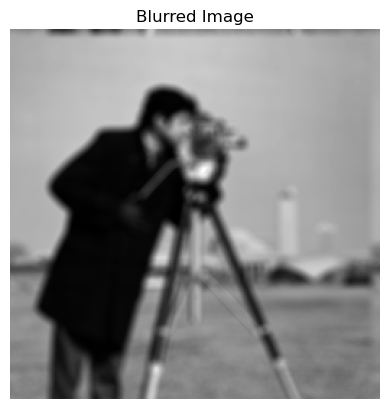

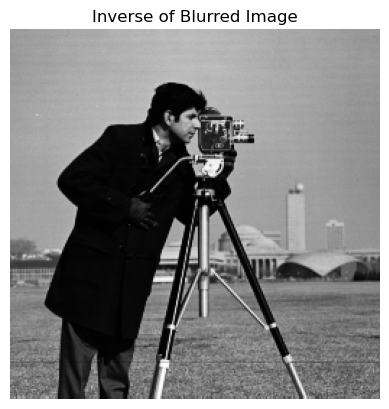

In [ ]:
h_d = disk(4)
h = np.zeros((256,256))
h[0:9,0:9] =h_d
h = np.roll(h, (-5,-5)) / np.sum(h)
h_freq = np.fft.fft2(h)
f_blurfreq = h_freq * np.fft.fft2(f) # apply to cameraman image
f_blur = np.real(np.fft.ifft2(f_blurfreq))

plt.figure()
plt.imshow(f_blur, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

psnr = PSNR(f, f_blur)
print("PSNR:", psnr)

# inverse filtered image
f_inv = f_blurfreq/h_freq
f_inv = np.real(np.fft.ifft2(f_inv))

psnr = PSNR(f, f_inv)
print("Restored PSNR:", psnr)

plt.figure()
plt.imshow(f_inv, cmap='gray')
plt.title('Inverse of Blurred Image')
plt.axis('off')


**1. Compare the restored image with the original image and the blurred image. How does the restored
image and the PSNR differ from the blurred image? Is it better or worse? Why?**

The restored PSNR is significantly better. The restored image has recovered details not present in the blurred image, leading to greater similarity with the original, and resulting in a much better PSNR.

Restored PSNR: -41.34064579729159


(-0.5, 255.5, 255.5, -0.5)

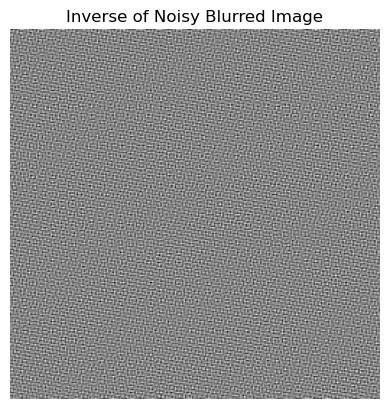

In [ ]:
# add gaussian noise to blurred image
f_noisy = skimage.util.random_noise(f_blur, mode='gaussian', mean=0, var=0.002)
f_blurfreq_noisy = np.fft.fft2(f_noisy)
# inverse noisy filtered image
f_inv_noisy = f_blurfreq_noisy/h_freq
f_inv_noisy = np.real(np.fft.ifft2(f_inv_noisy))


psnr = PSNR(f, f_inv_noisy)
print("Restored PSNR:", psnr)

plt.figure()
plt.imshow(f_inv_noisy, cmap='gray')
plt.title('Inverse of Noisy Blurred Image')
plt.axis('off')


**2. Compare the restored image with the restored image from the previous step. How does the restored
image and the PSNR differ from the previous restored image? Is it better or worse? Why?**

The restored is completely unrecognizable compared to the previous restored image, and has a negative PSNR instead of a positive one. It is much worse after the addition of noise, because if the degredation function approaches zero, then the noise will dominate in the inverse filtering, resulting in an amplification that destroys the final result.

**3. Can you draw any conclusions about inverse filtering when applied to noise degraded images?**

When inverse filtering is applied to noise degraded images, the the noise to signal ratio will dominate over the original signal term in the result, leading to a poor reconstruction.

Restored PSNR: 22.676561334926376


(-0.5, 255.5, 255.5, -0.5)

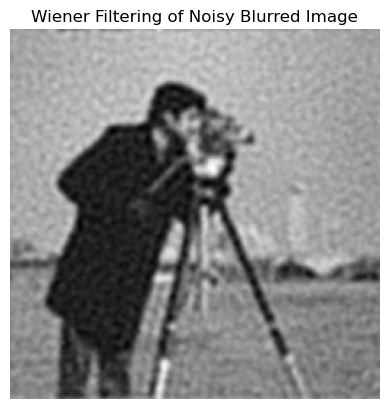

In [ ]:
# using 0.0625, as this is approximately the inverse of the original image PSNR
f_wiener = restoration.wiener(f_noisy, np.fft.fftshift(h), 0.0625 )

psnr = PSNR(f, f_wiener)
print("Restored PSNR:", psnr)

plt.figure()
plt.imshow(f_wiener, cmap='gray')
plt.title('Wiener Filtering of Noisy Blurred Image')
plt.axis('off')



**4. Compare the restored image with the restored image from the previous step. How does the restored
image and the PSNR differ from the previous restored image? Is it better or worse? Why? Explain it
in context with the concept behind Wiener filtering.**


Although the reconstruction is still impacted by noise, the result does look much better compared to the result obtained from inverse filtering, and the PSNR is positive. The reconstruction is superior with Wiener filtering because it incorporates both the degredation function and also image statistics into the restoration, not just the degredation function (as with inverse filtering). When there is no noise, the Wiener filter reduces to an inverse filter. When there is noise present, the high NSR keeps the denominator from evaluating to zero (when the degredation function approaches zero), acting to attenuate rather than amplify those frequencies.

**5. Can you draw any conclusions about Wiener filtering when applied to noise degraded images?**


When applied to noise degraded images, Weiner filtering performs well since it takes into account the SNR/NSR of the image to avoid amplifying noise in the restoration.

**Part 2. Colour Segmentation**

[0 0 0 ... 0 0 0]


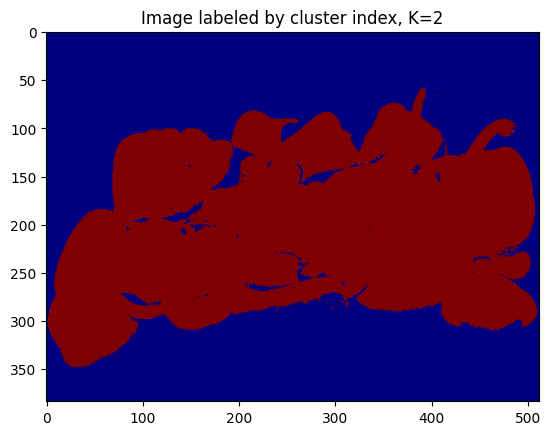

[0 0 0 ... 0 0 0]


Text(0.5, 1.0, 'Image labeled by cluster index, K=4')

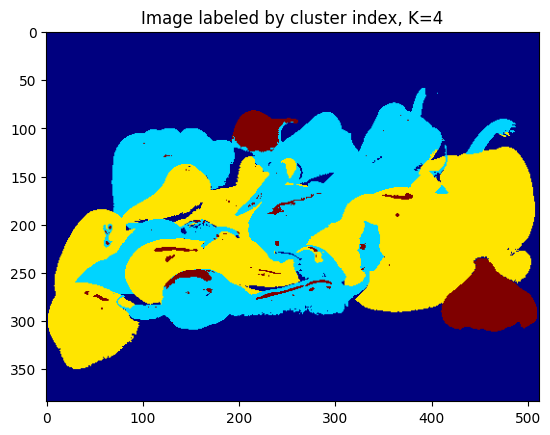

In [3]:
p_rgb = imread('peppers.png')
p_lab = rgb2lab(p_rgb)

K = 2
row = np.array([55, 200]) - 1
col = np.array([155, 400]) - 1

mu = p_lab[row,col]

m, n, ch = p_lab.shape
p_lab = np.reshape(p_lab, (m * n, ch), order='F')

kmeans = KMeans(n_clusters=K, init=mu)
kmeans.fit(p_lab)
output = kmeans.predict(p_lab)
cluster_idx = output
print(output)

#Label each pixel according to k-means
pixel_labels = np.reshape(cluster_idx, (m, n), order='F')
plt.figure()
plt.imshow(pixel_labels, cmap='jet')
plt.title('Image labeled by cluster index, K=2')
plt.show()

p_rgb = imread('peppers.png')
p_lab = rgb2lab(p_rgb)

K = 4
row = np.array([55, 130, 200, 280]) - 1
col = np.array([155, 110, 400, 470]) - 1

mu = p_lab[row,col]

m, n, ch = p_lab.shape
p_lab = np.reshape(p_lab, (m * n, ch), order='F')

kmeans = KMeans(n_clusters=K, init=mu)
kmeans.fit(p_lab)
output = kmeans.predict(p_lab)
cluster_idx = output
print(output)

#Label each pixel according to k-means
pixel_labels = np.reshape(cluster_idx, (m, n), order='F')
plt.figure()
plt.imshow(pixel_labels, cmap='jet')
plt.title('Image labeled by cluster index, K=4')


**13. For the various values of k, how did the clustering change? Explain.**

For k=2, we see two distinct clusters in the result- components of the foreground (the peppers) and background (purple cloth) of the original image. For k=4, 4 major color groupings in the image (red/orange, green/yellow, purple, and white) have formed the clusters. For this k value, the deepest shadows of the peppers have also been clustered with the purple cloth.

**14. What is the effect of the initial points on the final clusters? Does this impose any limitations? Why?**

The initial points dictate the initial cluster centroids, and can impact the local minimum that the algorithm converges to, changing the exact shape/placement of the final clusters. When the initial point is randomized instead of set, the clusters (for the k=4 case) are different every time. The particular starting point does impose limitations on which colors are associated in one cluster, and can then impact the final size and placement of the features in each cluster. For example, instead of green and yellow regions becoming a single cluster, yellow and white features may instead become a single cluster.


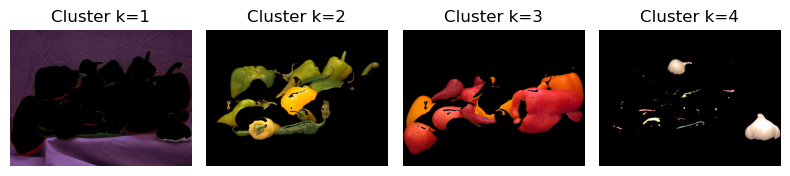

In [ ]:
# use original colors this time
plt.figure(figsize=(8, 4))
for k in range(K):
    mask = (pixel_labels == k)

    # mask out where other pixels are zero
    cluster_rgb = np.zeros_like(p_rgb)
    cluster_rgb[mask] = p_rgb[mask]

    plt.subplot(1, K, k + 1)
    # plt.figure()
    plt.imshow(cluster_rgb)
    plt.title(f'Cluster k={k+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()



**15. Include an image of each cluster and comment on the segmentation performance.**

The clustering did a reasonably good job at separating out each major colored region of the image. It tends to have the most trouble at the shadows and highlights, where the color of the area is similar to the parent region (red or green peppers), but the luminosity of the area is more similar to other regions in the image. As seen at k=1, the edges of the peppers are clustered with the similarly dark background, even though the actual colors of these two features are very different.

**Part 3. Chroma Subsampling**

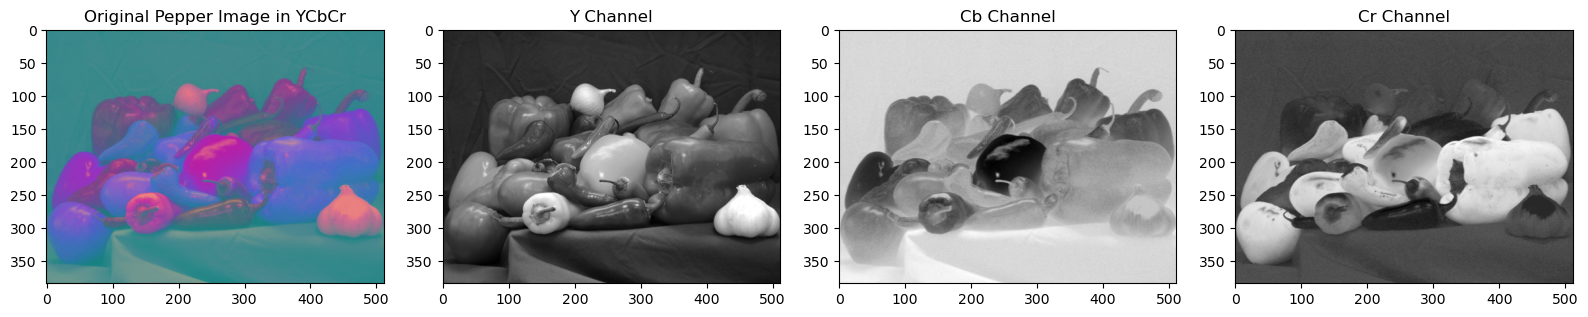

In [ ]:
peppers_chroma = rgb2ycbcr(imread('peppers.png'))/255 # convert to chroma space

Y_channel  = peppers_chroma[:, :, 0]
Cb_channel = peppers_chroma[:, :, 1]
Cr_channel = peppers_chroma[:, :, 2]

# plot each channel seprately
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(peppers_chroma)
plt.title('Original Pepper Image in YCbCr')

plt.subplot(1,4,2)
plt.imshow(Y_channel)
plt.title('Y Channel')

plt.subplot(1,4,3)
plt.imshow(Cb_channel)
plt.title('Cb Channel')

plt.subplot(1,4,4)
plt.imshow(Cr_channel)
plt.title('Cr Channel')
plt.tight_layout()
plt.show()

**6. Describe the Cb and Cr channel images. Why do they appear this way?**

The Cb image looks like it has a white background, with few dark peppers scattered in between, corresponding to the original yellow peppers. The Cr image looks like it has a dark background (purple tablecloth), with many white peppers, corresponding to the red peppers. This is because the Cb image is looking at the difference of the blue with the luminence, and the Cr image is looking at the difference between the red and the luminence of the red peppers and magenta tablecloth.

**7. Compare the level of image detail in the Cb and Cr images with the Y channel image. Which contains**
**more fine details? What does that say about the luma (Y) and chroma (Cb and Cr) channels?**

The Y channel contains much more fine detail compared to the Cb and Cr channels. Edges and textures in the peppers and tablecloth are a lot more visible in the Y channel, while the Cb and Cr channels are smoother with less detailed texture information. This shows that the luma channel carries most of the structural and detail information of the image, and the chroma channels hold mostly colour information.


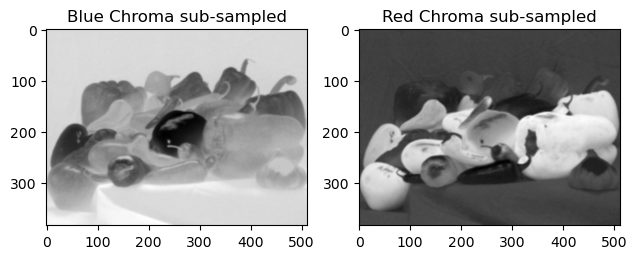

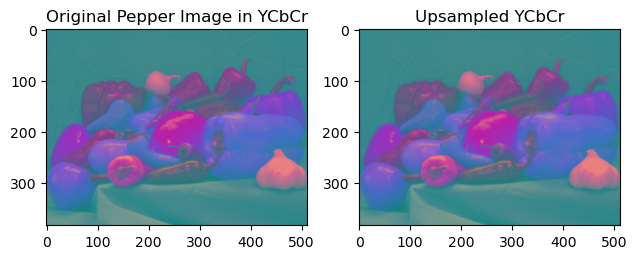

In [ ]:
# reduce the resolution of the chroma channels by factor of 2
Cb_down = transform.resize(Cb_channel, (Cb_channel.shape[0] // 2, Cb_channel.shape[1] // 2), anti_aliasing=True)
Cr_down = transform.resize(Cr_channel, (Cr_channel.shape[0] // 2, Cr_channel.shape[1] // 2), anti_aliasing=True)

# upsample using bilinear interpolation (1)
Cb_up = transform.resize(Cb_down, Cb_channel.shape, order=1)
Cr_up = transform.resize(Cr_down, Cr_channel.shape, order=1)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(Cb_up)
plt.title('Blue Chroma sub-sampled')

plt.subplot(1,2,2)
plt.imshow(Cr_up)
plt.title('Red Chroma sub-sampled')
plt.tight_layout()
plt.show()

# recombine upsamples with Y channel
peppers_chroma_upsampled = np.stack((Y_channel, Cb_up, Cr_up), axis=2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(peppers_chroma)
plt.title('Original Pepper Image in YCbCr')

plt.subplot(1,2,2)
plt.imshow(peppers_chroma_upsampled)
plt.title('Upsampled YCbCr')
plt.tight_layout()
plt.show()


**8. Compare the resulting image from chroma sub-sampling with the original image. How large are the visual differences?**

The visual differences between the chroma sub-sampled image and the original image are minimal. Most details and colors are preserved, and the images appear basically identical.

**9. Based on the resulting image, what can you say about chroma sub-sampling and its effect on image quality?**

Chroma sub-sampling reduces the resolution of the color channels without really affecting perceived image quality. This alligns with our knowledge of the HVS, as we know it is more sensitive to luminance details than to color information.

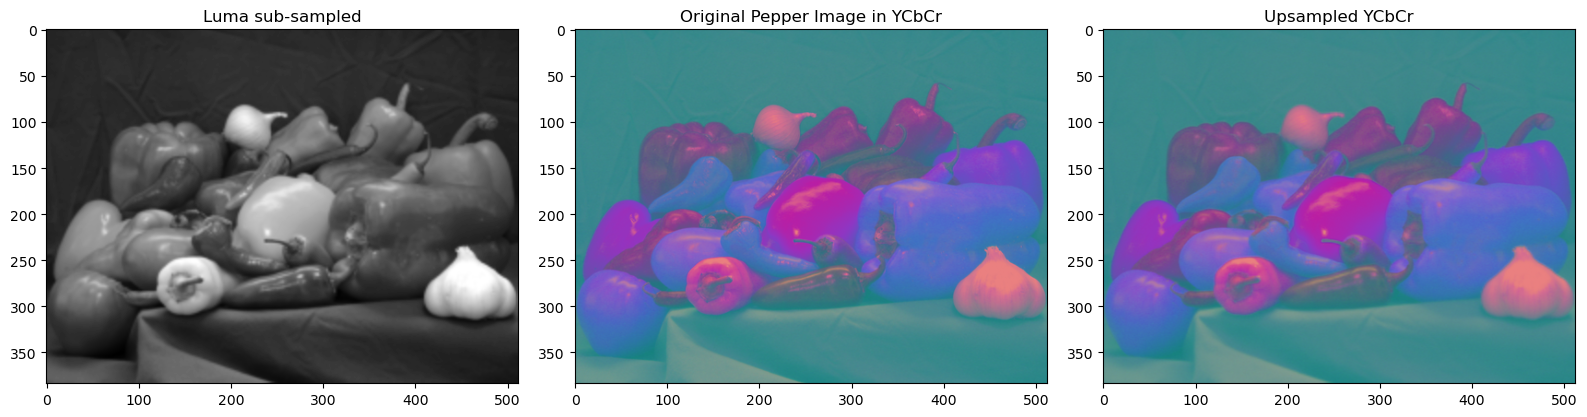

In [ ]:
# reduce the resolution of the Luma channel by a factor of 2
Y_down = transform.resize(Y_channel, (Y_channel.shape[0] // 2, Y_channel.shape[1] // 2), anti_aliasing=True)

Y_up = transform.resize(Y_down, Y_channel.shape, order=1) # 1 for bilinear interpolation

# recombine upsamples with Y channel
peppers_luma_upsampled = np.stack((Y_up, Cb_channel, Cr_channel), axis=2)

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.imshow(Y_up)
plt.title('Luma sub-sampled')

plt.subplot(1,3,2)
plt.imshow(peppers_chroma)
plt.title('Original Pepper Image in YCbCr')

plt.subplot(1,3,3)
plt.imshow(peppers_luma_upsampled)
plt.title('Upsampled YCbCr')
plt.tight_layout()
plt.show()

**10.Compare the resulting image from luma sub-sampling with the original image. How large are the visual
differences?**

The visual differences are fairly significant. The sub-sampled image appears blurrier, with edges, textures, and details reduced.

11.Based on the resulting image, what can you say about luma sub-sampling and its effect on image
quality?

Luma sub-sampling degrades image quality because the Y channel carries most of the structural and detail information. Reducing its resolution leads to a noticeable loss of edges, textures, and overall sharpness.

12.Compare the resulting image from luma sub-sampling with the image produced using chroma sub-
sampling. Which method performs better? Which is better for reducing network bandwidth while
preserving visual acuity? Why

Chroma sub-sampling performs much better than luma sub-sampling. The chroma sub-sampled image preserves almost all visible detail while reducing color resolution, making it nearly identical from the original. Therefore, chroma sub-sampling is better for reducing network bandwidth while maintaining visual acuity, since the HVS is more sensitive to luma than to chroma information

**Conclusion**

In this lab, we explored frequency-domain image restoration through inverse and Wiener filtering, finding that Wiener filtering is able to much more robustly reconstruct images in the presence of additive noise. We also implemented k-means clustering in the L∗a∗b∗ color space for color segmentation, noting that the final cluster position and size is dictated by the initial point used. The number of clusters used also changed the interpretability and usefulness of the final segmentation. We then looked at chroma sub-sampling in the YCbCr color space as a means of image compression. It was found that chroma sub-sampling has a limited impact on the resulting image quality compared to the degredation observed with luma sub-sampling, making it the superior sub-sampling method.